## Import datasets

In [1]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
from model_GN import *
from utils import *

## Data transformation

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(28), ], p = 0.1),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_data = datasets.CIFAR10(root=".", train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               RandomApply(
               p=0.1
               CenterCrop(size=(28, 28))
           )
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
           )

In [6]:
classes = train_data.classes

class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


In [7]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

## Sample image

images.shape: torch.Size([128, 3, 32, 32])


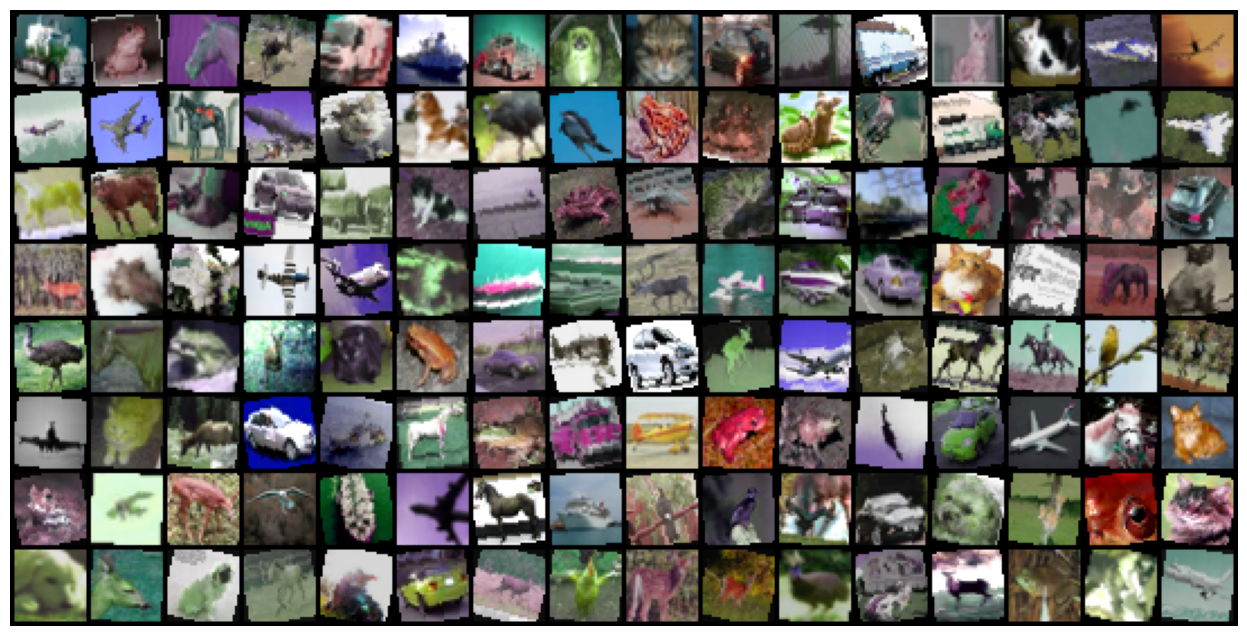

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Neural net summary

In [9]:
get_summary(Net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           3,456
              ReLU-6           [-1, 24, 32, 32]               0
         GroupNorm-7           [-1, 24, 32, 32]              48
           Dropout-8           [-1, 24, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             192
             ReLU-10            [-1, 8, 32, 32]               0
        GroupNorm-11            [-1, 8, 32, 32]              16
          Dropout-12            [-1, 8, 32, 32]               0
        MaxPool2d-13            [-1, 8, 16, 16]               0
           Conv2d-14           [-1, 16,

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

## Training the data and calculating validation results

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# New Line
train_criterion = nn.CrossEntropyLoss() #Loss function
test_criterion = nn.CrossEntropyLoss() #Loss function
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, train_criterion)
    print(train_acc_val)
    test_acc_val, test_loss = test(model, device, test_loader, test_criterion)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

Epoch 1


Train: Loss=1.7276 Batch_id=390 Accuracy=33.65: 100%|█| 391/391 [01:37<00:00,  4

33.654


Test set: Average loss: 1.4742, Accuracy: 4673/10000 (46.73%)

Epoch 1: SGD lr 0.0500 -> 0.0400
Epoch 2


Train: Loss=1.2900 Batch_id=390 Accuracy=47.18: 100%|█| 391/391 [01:41<00:00,  3

47.182


Test set: Average loss: 1.2722, Accuracy: 5366/10000 (53.66%)

Epoch 2: SGD lr 0.0400 -> 0.0320
Epoch 3


Train: Loss=1.3157 Batch_id=390 Accuracy=52.73: 100%|█| 391/391 [01:41<00:00,  3

52.73


Test set: Average loss: 1.1737, Accuracy: 5746/10000 (57.46%)

Epoch 3: SGD lr 0.0320 -> 0.0256
Epoch 4


Train: Loss=1.1854 Batch_id=390 Accuracy=55.92: 100%|█| 391/391 [01:47<00:00,  3

55.924


Test set: Average loss: 1.0979, Accuracy: 6058/10000 (60.58%)

Epoch 4: SGD lr 0.0256 -> 0.0205
Epoch 5


Train: Loss=1.0550 Batch_id=390 Accuracy=58.25: 100%|█| 391/391 [01:41<00:00,  3

58.25


Test set: Average loss: 1.0625, Accuracy: 6216/10000 (62.16%)

Epoch 5: SGD lr 0.0205 -> 0.0164
Epoch 6


Train: Loss=1.1869 Batch_id=390 Accuracy=59.90: 100%|█| 391/391 [01:46<00:00,  3

59.898


Test set: Average loss: 0.9960, Accuracy: 6480/10000 (64.80%)

Epoch 6: SGD lr 0.0164 -> 0.0131
Epoch 7


Train: Loss=1.1965 Batch_id=390 Accuracy=60.96: 100%|█| 391/391 [01:48<00:00,  3

60.956


Test set: Average loss: 0.9849, Accuracy: 6547/10000 (65.47%)

Epoch 7: SGD lr 0.0131 -> 0.0105
Epoch 8


Train: Loss=1.2295 Batch_id=390 Accuracy=62.39: 100%|█| 391/391 [01:44<00:00,  3

62.386


Test set: Average loss: 0.9354, Accuracy: 6693/10000 (66.93%)

Epoch 8: SGD lr 0.0105 -> 0.0084
Epoch 9


Train: Loss=1.0959 Batch_id=390 Accuracy=62.91: 100%|█| 391/391 [01:44<00:00,  3

62.91


Test set: Average loss: 0.9363, Accuracy: 6730/10000 (67.30%)

Epoch 9: SGD lr 0.0084 -> 0.0067
Epoch 10


Train: Loss=1.1454 Batch_id=390 Accuracy=63.37: 100%|█| 391/391 [02:07<00:00,  3

63.372


Test set: Average loss: 0.9240, Accuracy: 6758/10000 (67.58%)

Epoch 10: SGD lr 0.0067 -> 0.0054
Epoch 11


Train: Loss=1.1195 Batch_id=390 Accuracy=63.84: 100%|█| 391/391 [01:52<00:00,  3

63.84


Test set: Average loss: 0.9155, Accuracy: 6801/10000 (68.01%)

Epoch 11: SGD lr 0.0054 -> 0.0043
Epoch 12


Train: Loss=1.0347 Batch_id=390 Accuracy=64.39: 100%|█| 391/391 [01:57<00:00,  3

64.386


Test set: Average loss: 0.8892, Accuracy: 6895/10000 (68.95%)

Epoch 12: SGD lr 0.0043 -> 0.0034
Epoch 13


Train: Loss=0.8236 Batch_id=390 Accuracy=64.35: 100%|█| 391/391 [02:13<00:00,  2

64.348


Test set: Average loss: 0.8928, Accuracy: 6857/10000 (68.57%)

Epoch 13: SGD lr 0.0034 -> 0.0027
Epoch 14


Train: Loss=0.8953 Batch_id=390 Accuracy=64.66: 100%|█| 391/391 [01:53<00:00,  3

64.658


Test set: Average loss: 0.8700, Accuracy: 6963/10000 (69.63%)

Epoch 14: SGD lr 0.0027 -> 0.0022
Epoch 15


Train: Loss=1.2594 Batch_id=390 Accuracy=64.77: 100%|█| 391/391 [01:47<00:00,  3

64.77


Test set: Average loss: 0.8841, Accuracy: 6935/10000 (69.35%)

Epoch 15: SGD lr 0.0022 -> 0.0018
Epoch 16


Train: Loss=0.9561 Batch_id=390 Accuracy=65.39: 100%|█| 391/391 [01:43<00:00,  3

65.394


Test set: Average loss: 0.8701, Accuracy: 6963/10000 (69.63%)

Epoch 16: SGD lr 0.0018 -> 0.0014
Epoch 17


Train: Loss=1.1361 Batch_id=390 Accuracy=65.22: 100%|█| 391/391 [01:43<00:00,  3

65.224


Test set: Average loss: 0.8742, Accuracy: 6949/10000 (69.49%)

Epoch 17: SGD lr 0.0014 -> 0.0011
Epoch 18


Train: Loss=0.9528 Batch_id=390 Accuracy=65.58: 100%|█| 391/391 [01:41<00:00,  3

65.576


Test set: Average loss: 0.8584, Accuracy: 6989/10000 (69.89%)

Epoch 18: SGD lr 0.0011 -> 0.0009
Epoch 19


Train: Loss=1.0428 Batch_id=390 Accuracy=65.56: 100%|█| 391/391 [01:41<00:00,  3

65.564


Test set: Average loss: 0.8671, Accuracy: 6978/10000 (69.78%)

Epoch 19: SGD lr 0.0009 -> 0.0007
Epoch 20


Train: Loss=0.9629 Batch_id=390 Accuracy=65.57: 100%|█| 391/391 [01:42<00:00,  3

65.568


Test set: Average loss: 0.8601, Accuracy: 6989/10000 (69.89%)

Epoch 20: SGD lr 0.0007 -> 0.0006


## Plots

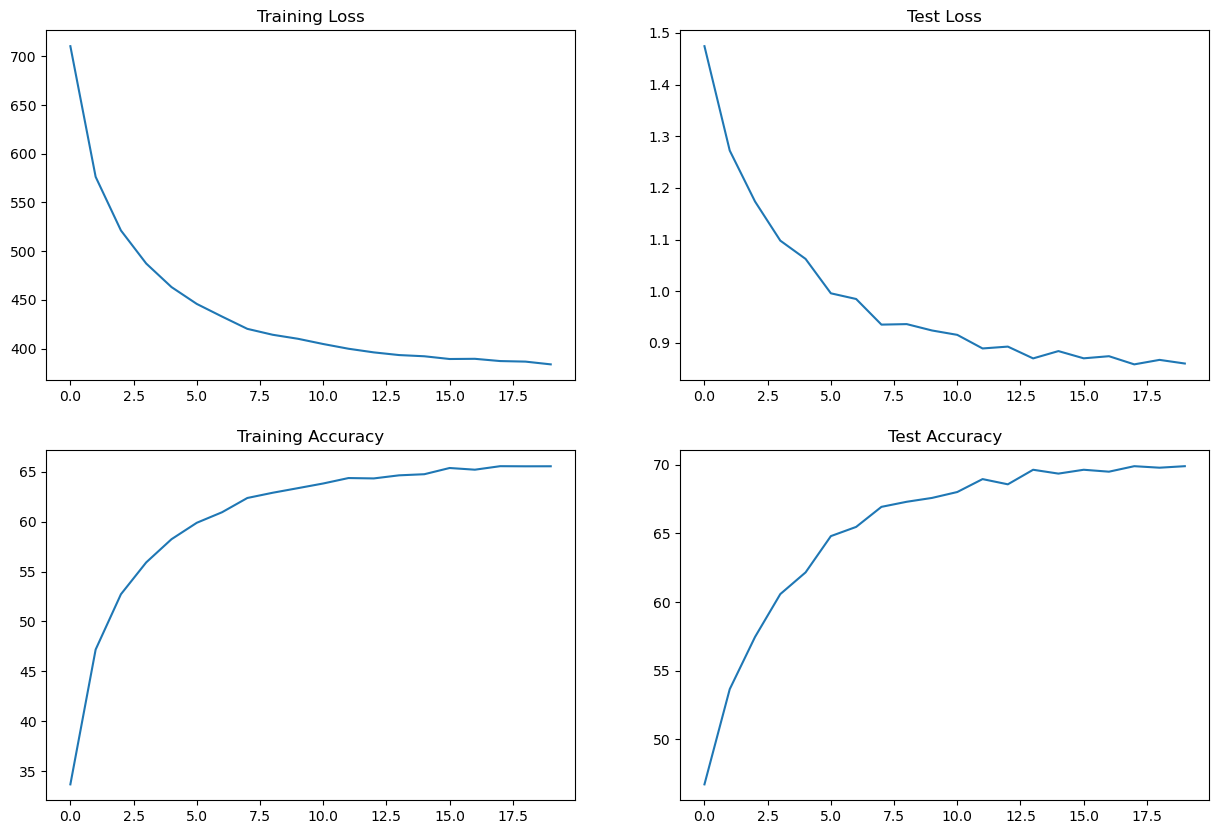

In [12]:
plot_loss(train_losses, train_acc, test_losses, test_acc)

## Misclassified dataset

In [13]:
model.eval()

incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): 
        incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
        incorrect_labels.append(target[idxs_mask].cpu().numpy())
        incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy())

In [14]:
print(incorrect_labels[0])
print(incorrect_pred[0])

[5 7 0 4 4 5 9 7 4 6 1 3 8 1 6 4 6 4 4 2 6 2 2 9 7 0 2 7 3 3 9]
[3 0 9 7 2 3 0 4 6 3 9 2 7 0 7 5 3 0 0 9 5 5 4 7 3 2 0 6 2 5 8]


In [15]:
print(incorrect_examples[0][0])

[[[0.99607843 0.9843137  0.9843137  ... 0.9843137  0.9882353  0.9882353 ]
  [1.         0.99215686 0.99215686 ... 1.         1.         1.        ]
  [1.         0.9882353  0.9882353  ... 0.99607843 0.99607843 0.99215686]
  ...
  [0.9411765  0.9254902  0.9607843  ... 0.38431373 0.68235296 0.9411765 ]
  [1.         0.99607843 0.9764706  ... 0.3254902  0.30980393 0.6156863 ]
  [1.         0.9843137  0.9764706  ... 0.69803923 0.4117647  0.4117647 ]]

 [[0.99607843 0.9843137  0.9843137  ... 0.9843137  0.9882353  0.9882353 ]
  [1.         0.99215686 0.99215686 ... 1.         1.         1.        ]
  [1.         0.9882353  0.9882353  ... 0.99607843 0.99607843 0.99215686]
  ...
  [0.91764706 0.90588236 0.972549   ... 0.37254903 0.6784314  0.9411765 ]
  [1.         0.99607843 1.         ... 0.3137255  0.30588236 0.6156863 ]
  [0.9843137  0.9764706  0.9843137  ... 0.6901961  0.40392157 0.41568628]]

 [[0.99607843 0.9843137  0.9843137  ... 0.9843137  0.9882353  0.9882353 ]
  [1.         0.992156

## Sample Misclassified Images

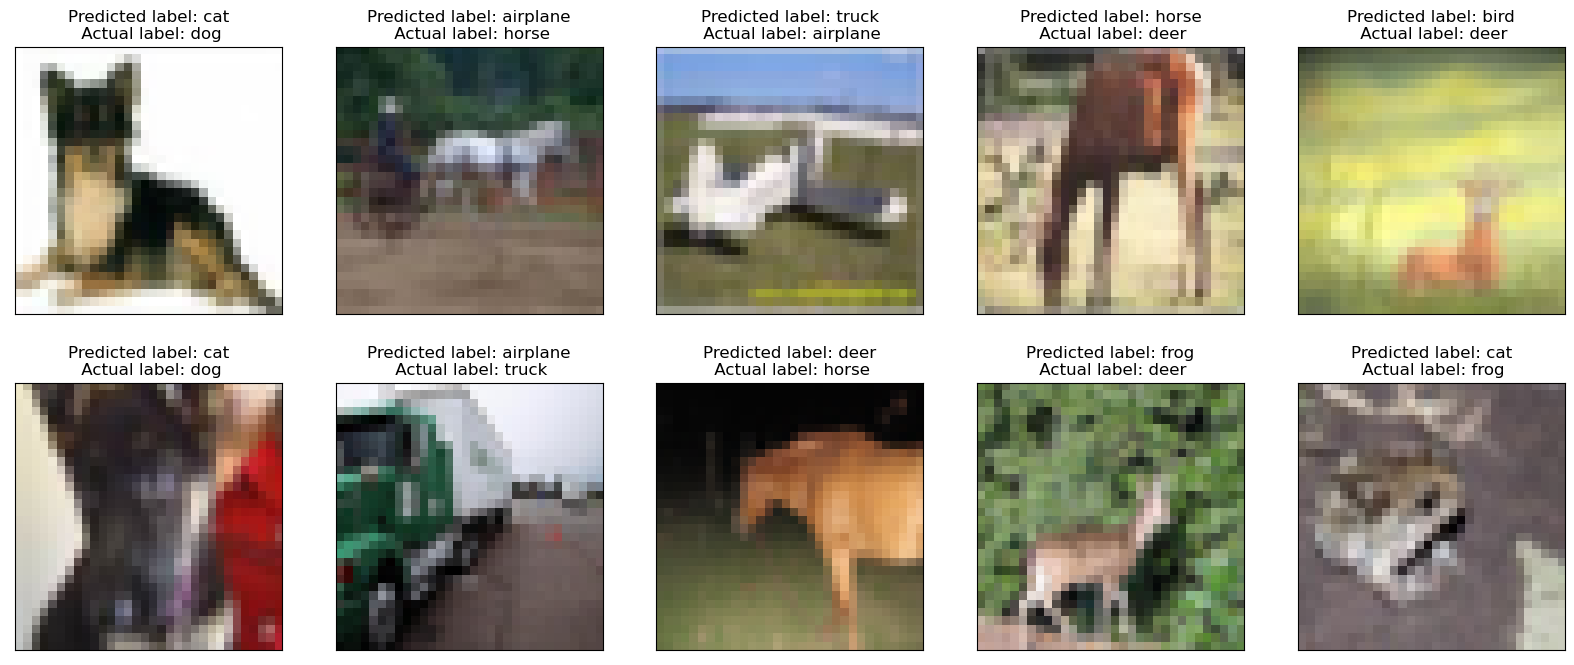

In [16]:
import numpy as np
fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = incorrect_examples[0][idx]
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(incorrect_examples[0][idx], (1, 2, 0)))
    ax.set_title(f"Predicted label: {classes[incorrect_pred[0][idx]]}\n Actual label: {classes[incorrect_labels[0][idx]]}")
    